In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tushare as ts
ts.set_token('your_token_here')
pro = ts.pro_api()

In [6]:
start_date = '2025-01-01'
end_date = '2026-02-22'

ts_code = '518880.SH' 
#ts_code = '513100.SH' 
#ts_code = '159920.SZ'

获取数据: 2025-01-02 ~ 2025-12-31，共 243 条
             open  close  pre_close
trade_date                         
2025-01-02  5.975  5.977      5.928
2025-01-03  6.020  6.029      5.977
2025-01-06  6.023  5.990      6.029
2025-01-07  5.992  6.000      5.990
2025-01-08  6.010  6.030      6.000
  标的: 518880.SH
  策略: Open > 上一交易日 Close 则持仓
  回测: 2025-01-02 ~ 2025-12-31
  策略收益率:    205.40%
  基准收益率:     55.61%
  超额收益:      149.78%
-------------------------------------------------------
  策略最大回撤:   -1.49%
  基准最大回撤:  -11.53%
  策略Sharpe:      9.16
  基准Sharpe:      2.51
  持仓比例:        61.3%
  交易胜率:        87.2%


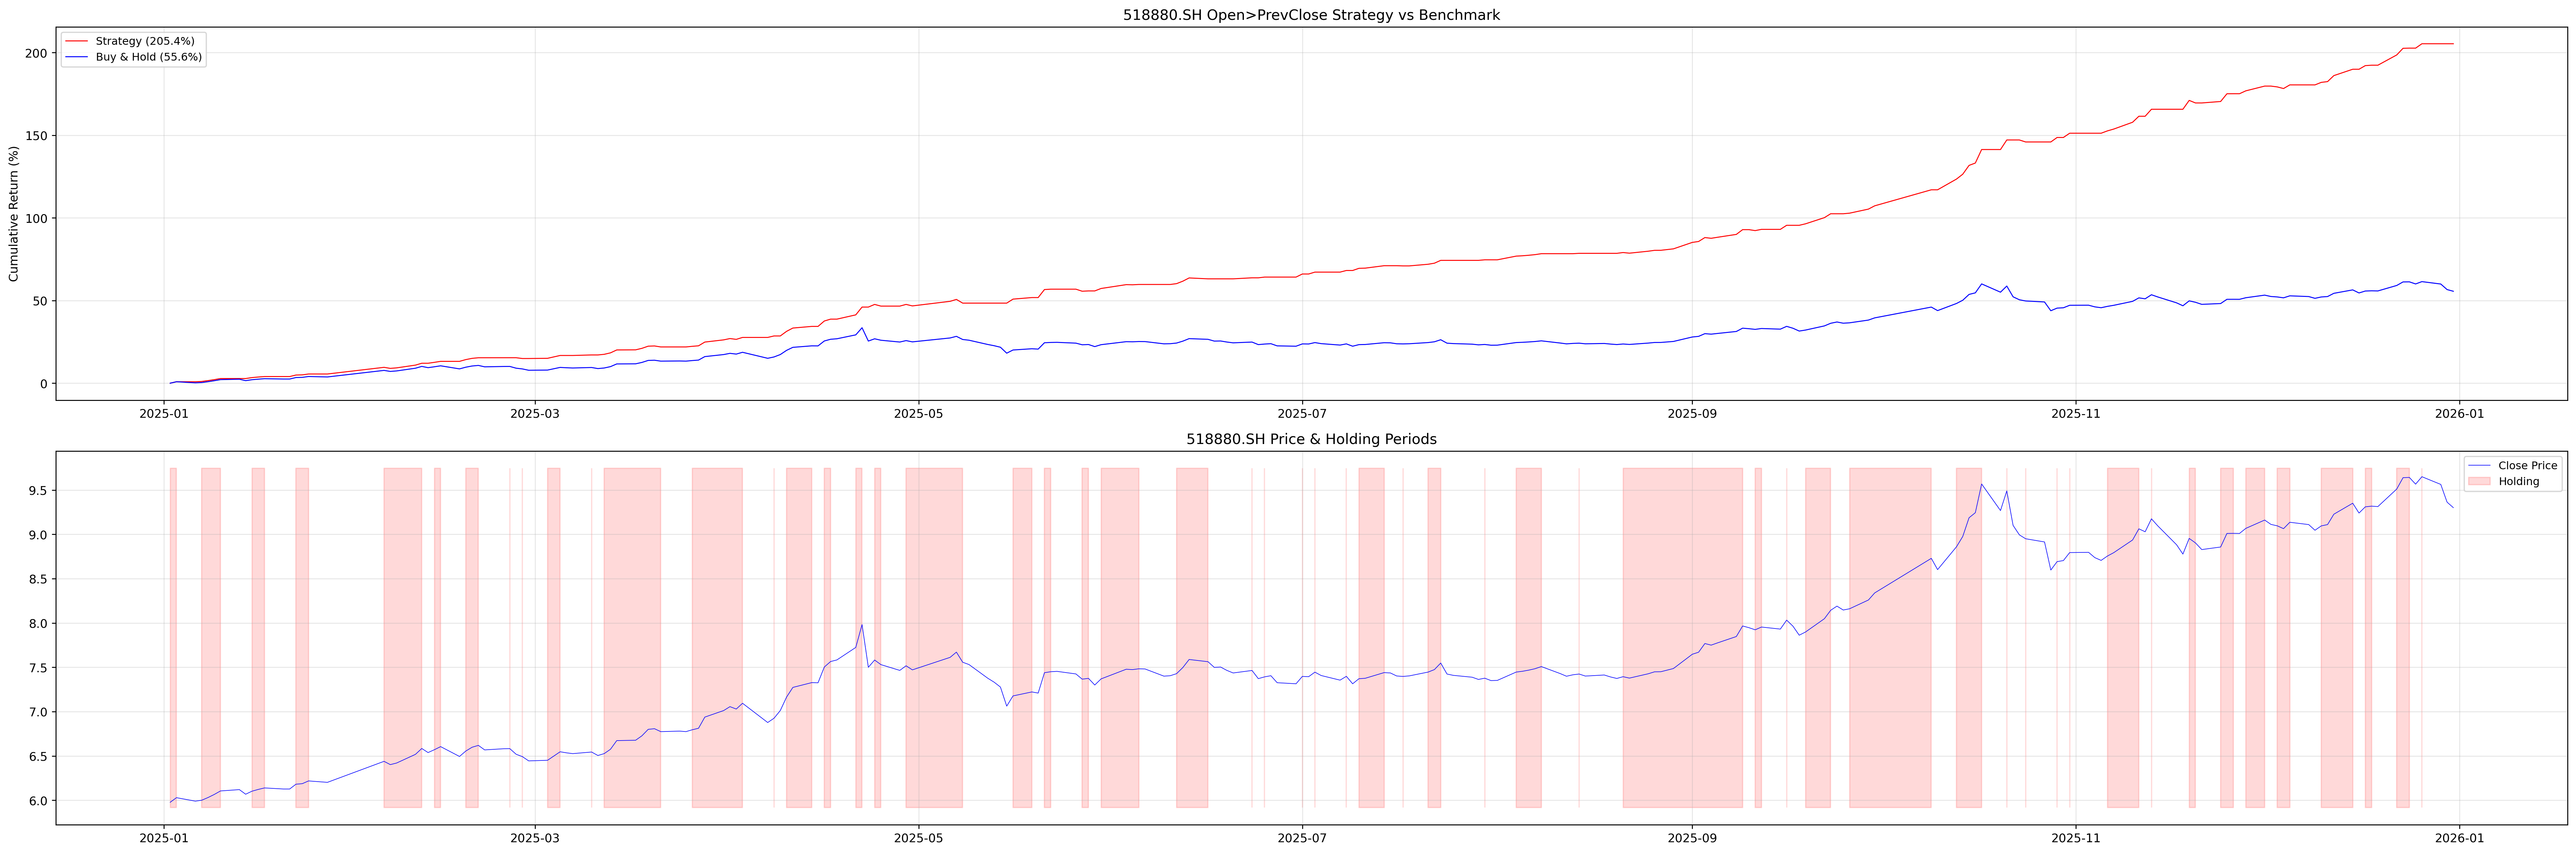

In [7]:
#--------------------------------------获取数据------------------------------------------------------------
data = pro.fund_daily(ts_code=ts_code, start_date=start_date, end_date=end_date)

#--------------------------------------数据整理------------------------------------------------------------
data = data[::-1].reset_index(drop=True)
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data.set_index('trade_date', inplace=True)

print(f"获取数据: {data.index[0].strftime('%Y-%m-%d')} ~ {data.index[-1].strftime('%Y-%m-%d')}，共 {len(data)} 条")
print(data[['open', 'close', 'pre_close']].head())

#--------------------------------------策略信号: Open > 上一交易日 Close ------------------------------------
# 当日开盘价 > 上一交易日收盘价 → 持仓（信号=1）
data['signal'] = (data['open'] > data['pre_close']).astype(int)

#--------------------------------------回测模块------------------------------------------------------------
# 基准收益（买入持有）
data['daily_ret'] = data['close'].pct_change().fillna(0)
data['prod_base'] = (1 + data['daily_ret']).cumprod() - 1

# 策略收益（当日信号当日生效：开盘判断，持有到收盘）
data['strat_ret'] = np.where(data['signal'] == 1, data['daily_ret'], 0)
data['prod_strat'] = (1 + data['strat_ret']).cumprod() - 1

# ---- 风险指标 ----
strat_return = data['prod_strat'].iloc[-1]
base_return = data['prod_base'].iloc[-1]
excess = strat_return - base_return
hold_pct = data['signal'].mean() * 100

cum_s = (1 + data['strat_ret']).cumprod()
max_dd_s = (cum_s / cum_s.cummax() - 1).min()
cum_b = (1 + data['daily_ret']).cumprod()
max_dd_b = (cum_b / cum_b.cummax() - 1).min()

sharpe_s = data['strat_ret'].mean() / (data['strat_ret'].std() + 1e-10) * np.sqrt(252)
sharpe_b = data['daily_ret'].mean() / (data['daily_ret'].std() + 1e-10) * np.sqrt(252)

win_days = data[data['signal'] == 1]
win_rate = (win_days['daily_ret'] > 0).mean() * 100

print("=" * 55)
print(f"  标的: {ts_code}")
print(f"  策略: Open > 上一交易日 Close 则持仓")
print(f"  回测: {data.index[0].strftime('%Y-%m-%d')} ~ {data.index[-1].strftime('%Y-%m-%d')}")
print("=" * 55)
print(f"  策略收益率:  {strat_return*100:>8.2f}%")
print(f"  基准收益率:  {base_return*100:>8.2f}%")
print(f"  超额收益:    {excess*100:>8.2f}%")
print("-" * 55)
print(f"  策略最大回撤: {max_dd_s*100:>7.2f}%")
print(f"  基准最大回撤: {max_dd_b*100:>7.2f}%")
print(f"  策略Sharpe:   {sharpe_s:>7.2f}")
print(f"  基准Sharpe:   {sharpe_b:>7.2f}")
print(f"  持仓比例:     {hold_pct:>7.1f}%")
print(f"  交易胜率:     {win_rate:>7.1f}%")
print("=" * 55)

# ---- 绘图 ----
fig, axes = plt.subplots(2, 1, figsize=(30, 10), dpi=256)

# 图1: 策略 vs 基准 累计收益
axes[0].set_title(f"{ts_code} Open>PrevClose Strategy vs Benchmark", fontsize=12)
axes[0].plot(data.index, data['prod_strat']*100, color="red", linewidth=0.8,
             label=f"Strategy ({strat_return*100:.1f}%)")
axes[0].plot(data.index, data['prod_base']*100, color="blue", linewidth=0.8,
             label=f"Buy & Hold ({base_return*100:.1f}%)")
axes[0].set_ylabel("Cumulative Return (%)")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# 图2: 价格与持仓区间
axes[1].set_title(f"{ts_code} Price & Holding Periods", fontsize=12)
axes[1].plot(data.index, data['close'], color="blue", linewidth=0.5, label="Close Price")
hold_mask = data['signal'] == 1
axes[1].fill_between(data.index, data['close'].min()*0.99, data['close'].max()*1.01,
                     where=hold_mask, alpha=0.15, color='red', label="Holding")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()